In [1]:
# Import libraries

import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english')) 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import textblob
import matplotlib.pyplot as plt

In [12]:
# Load dataset

tweet_df = pd.read_pickle('../clean_data.pkl')

tweet_df.reset_index(drop=True, inplace=True)
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418624 entries, 0 to 418623
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   411234 non-null  object             
 1   author_id            411234 non-null  object             
 2   text                 411234 non-null  object             
 3   created_at           411234 non-null  datetime64[ns, UTC]
 4   entities             409126 non-null  object             
 5   public_metrics       411234 non-null  object             
 6   referenced_tweets    387530 non-null  object             
 7   in_reply_to_user_id  14026 non-null   object             
 8   geo                  1454 non-null    object             
 9   users                3695 non-null    object             
 10  tweets               3695 non-null    object             
 11  places               932 non-null     object             
 12  ne

In [13]:
# Get mentions from tweets

def get_mention(var, key):
    if type(var)==float:
        return np.nan
    if key in var:
        return [user['username'] for user in var[key]]
    else: 
        return np.nan

tweet_df['mentions'] = tweet_df['entities'].apply(get_mention, args=('mentions',))

In [14]:
# Get public metrics - retweet, like, quote, reply

def get_count(var, key):
    if type(var) is float:
        return np.nan
    else: return var[key]

tweet_df['retweet_count'] = tweet_df.public_metrics.apply(get_count, args=('retweet_count',))
tweet_df['like_count'] = tweet_df.public_metrics.apply(get_count, args=('like_count',))
tweet_df['reply_count'] = tweet_df.public_metrics.apply(get_count, args=('reply_count',))
tweet_df['quote_count'] = tweet_df.public_metrics.apply(get_count, args=('quote_count',))

In [15]:
# Convert created_at to datetime object
tweet_df['created_at'] = pd.to_datetime(tweet_df.created_at)

#  Drop unnecesary columns
tweet_df.drop(['entities', 'public_metrics', 'in_reply_to_user_id', 'users', 'tweets',\
               'newest_id', 'oldest_id', 'result_count', 'next_token', 'geo', 'places'], inplace=True, axis=1)

# Drop rows where all values are NA
tweet_df.dropna(inplace=True, subset=['text'])

# drop duplicate rows
tweet_df.drop_duplicates(subset='text', ignore_index=True, inplace=True)

In [16]:
# Remove RT, links, punctuation, newline from tweet

def clean_tweets(tweet):
    if type(tweet) == float:
        return np.nan
    else:
        tweet = tweet.lower()
        # remove RT
        tweet = re.sub(r'^rt[\s]+', '', tweet)
        # remove liks
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
        # remove \n
        tweet = tweet.replace('\n', ' ')
        # remove user mentions
        tweet = re.sub(r'@[\w]*', '', tweet)
        # remove punctuation
        tweet = re.sub('[.!,:;?]', '', tweet)
        # tokenize tweets
        tweet = WhitespaceTokenizer().tokenize(tweet)
        # remove stop word
        tweet = [w for w in tweet if not w in stop_words]

        return tweet

tweet_df['clean_text'] = tweet_df['text'].apply(clean_tweets)

# join tokens
tweet_df['joined_text'] = ''
for i in range(len(tweet_df['clean_text'])):
    tweet_df['joined_text'].iloc[i] = ' '.join(tweet_df['clean_text'].iloc[i])

## Word cloud representing popular words

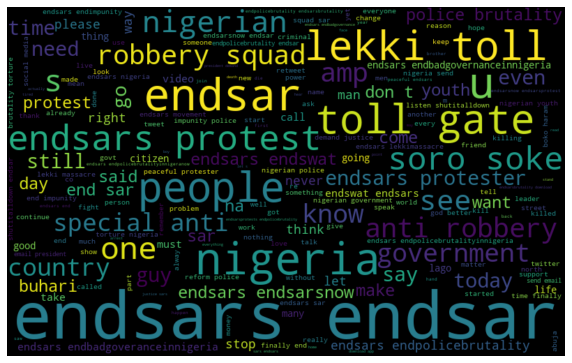

In [17]:
all_words = ' '.join([text for text in tweet_df['joined_text']])
wordcloud = WordCloud(width=800, height=500, background_color='black',random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Tweet with the highest reply count

In [18]:
tweet_df.iloc[tweet_df['reply_count'].argmax()][['text', 'username', 'reply_count']].values

array(['I just lost my kid brother to these animals ffs! 💔💔💔 #EndSARS',
       'Tcheek_', 1349.0], dtype=object)

### Tweet with the highest like count

In [19]:
tweet_df.iloc[tweet_df['like_count'].argmax()]

id                                                   1319065639319867392
author_id                                                       21247989
text                                                     #EndSARS NOW! 💔
created_at                                     2020-10-21 23:58:50+00:00
referenced_tweets                                                    NaN
withheld                                                             NaN
user_public_metrics    {'followers_count': 2860190, 'following_count'...
user_location                                 Slauson Hills, Los Angeles
user_created_at                                 2009-02-18T22:17:46.000Z
user_name                                                       Chilombo
username                                                       JheneAiko
user_verified                                                       True
possibly_sensitive                                                   NaN
context_annotations                                

### Tweet with the highest retweet

In [20]:
tweet_df.iloc[tweet_df['retweet_count'].argmax()]

id                                                   1341155663758708740
author_id                                            1324704785220751360
text                    RT @rihanna: #ENDSARS 🇳🇬 https://t.co/59lrs8JnDA
created_at                                     2020-12-21 22:56:42+00:00
referenced_tweets      [{'type': 'retweeted', 'id': '1318693601996464...
withheld                                                             NaN
user_public_metrics    {'followers_count': 27, 'following_count': 556...
user_location                                                        NaN
user_created_at                                 2020-11-06T13:27:36.000Z
user_name                                                 Miracle Friday
username                                                 jazzieblack4577
user_verified                                                      False
possibly_sensitive                                                   NaN
context_annotations                                

### Number of tweets by month

<AxesSubplot:xlabel='created_at', ylabel='tweet_count'>

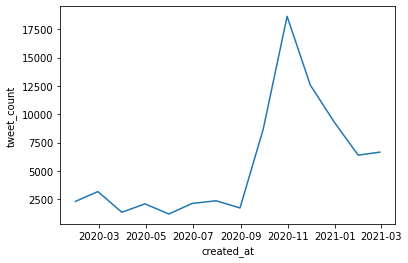

In [21]:
date_tweet = tweet_df.groupby([pd.Grouper(key='created_at', freq='M')]).size()
date_tweet = pd.DataFrame(date_tweet, columns=['tweet_count'])
date_tweet.reset_index(drop=False, inplace=True)
sns.lineplot(date_tweet['created_at'], date_tweet['tweet_count'], )

### Number of tweets by country

In [22]:
Country = [
    ('US', 'United States'),
    ('AF', 'Afghanistan'),
    ('AL', 'Albania'),
    ('DZ', 'Algeria'),
    ('AS', 'American Samoa'),
    ('AD', 'Andorra'),
    ('AO', 'Angola'),
    ('AI', 'Anguilla'),
    ('AQ', 'Antarctica'),
    ('AG', 'Antigua And Barbuda'),
    ('AR', 'Argentina'),
    ('AM', 'Armenia'),
    ('AW', 'Aruba'),
    ('AU', 'Australia'),
    ('AT', 'Austria'),
    ('AZ', 'Azerbaijan'),
    ('BS', 'Bahamas'),
    ('BH', 'Bahrain'),
    ('BD', 'Bangladesh'),
    ('BB', 'Barbados'),
    ('BY', 'Belarus'),
    ('BE', 'Belgium'),
    ('BZ', 'Belize'),
    ('BJ', 'Benin'),
    ('BM', 'Bermuda'),
    ('BT', 'Bhutan'),
    ('BO', 'Bolivia'),
    ('BA', 'Bosnia And Herzegowina'),
    ('BW', 'Botswana'),
    ('BV', 'Bouvet Island'),
    ('BR', 'Brazil'),
    ('BN', 'Brunei Darussalam'),
    ('BG', 'Bulgaria'),
    ('BF', 'Burkina Faso'),
    ('BI', 'Burundi'),
    ('KH', 'Cambodia'),
    ('CM', 'Cameroon'),
    ('CA', 'Canada'),
    ('CV', 'Cape Verde'),
    ('KY', 'Cayman Islands'),
    ('CF', 'Central African Rep'),
    ('TD', 'Chad'),
    ('CL', 'Chile'),
    ('CN', 'China'),
    ('CX', 'Christmas Island'),
    ('CC', 'Cocos Islands'),
    ('CO', 'Colombia'),
    ('KM', 'Comoros'),
    ('CG', 'Congo'),
    ('CK', 'Cook Islands'),
    ('CR', 'Costa Rica'),
    ('CI', 'Cote D`ivoire'),
    ('HR', 'Croatia'),
    ('CU', 'Cuba'),
    ('CY', 'Cyprus'),
    ('CZ', 'Czech Republic'),
    ('DK', 'Denmark'),
    ('DJ', 'Djibouti'),
    ('DM', 'Dominica'),
    ('DO', 'Dominican Republic'),
    ('TP', 'East Timor'),
    ('EC', 'Ecuador'),
    ('EG', 'Egypt'),
    ('SV', 'El Salvador'),
    ('GQ', 'Equatorial Guinea'),
    ('ER', 'Eritrea'),
    ('EE', 'Estonia'),
    ('ET', 'Ethiopia'),
    ('FK', 'Falkland Islands (Malvinas)'),
    ('FO', 'Faroe Islands'),
    ('FJ', 'Fiji'),
    ('FI', 'Finland'),
    ('FR', 'France'),
    ('GF', 'French Guiana'),
    ('PF', 'French Polynesia'),
    ('TF', 'French S. Territories'),
    ('GA', 'Gabon'),
    ('GM', 'Gambia'),
    ('GE', 'Georgia'),
    ('DE', 'Germany'),
    ('GH', 'Ghana'),
    ('GI', 'Gibraltar'),
    ('GR', 'Greece'),
    ('GL', 'Greenland'),
    ('GD', 'Grenada'),
    ('GP', 'Guadeloupe'),
    ('GU', 'Guam'),
    ('GT', 'Guatemala'),
    ('GN', 'Guinea'),
    ('GW', 'Guinea-bissau'),
    ('GY', 'Guyana'),
    ('HT', 'Haiti'),
    ('HN', 'Honduras'),
    ('HK', 'Hong Kong'),
    ('HU', 'Hungary'),
    ('IS', 'Iceland'),
    ('IN', 'India'),
    ('ID', 'Indonesia'),
    ('IR', 'Iran'),
    ('IQ', 'Iraq'),
    ('IE', 'Ireland'),
    ('IL', 'Israel'),
    ('IT', 'Italy'),
    ('JM', 'Jamaica'),
    ('JP', 'Japan'),
    ('JO', 'Jordan'),
    ('KZ', 'Kazakhstan'),
    ('KE', 'Kenya'),
    ('KI', 'Kiribati'),
    ('KP', 'Korea (North)'),
    ('KR', 'Korea (South)'),
    ('KW', 'Kuwait'),
    ('KG', 'Kyrgyzstan'),
    ('LA', 'Laos'),
    ('LV', 'Latvia'),
    ('LB', 'Lebanon'),
    ('LS', 'Lesotho'),
    ('LR', 'Liberia'),
    ('LY', 'Libya'),
    ('LI', 'Liechtenstein'),
    ('LT', 'Lithuania'),
    ('LU', 'Luxembourg'),
    ('MO', 'Macau'),
    ('MK', 'Macedonia'),
    ('MG', 'Madagascar'),
    ('MW', 'Malawi'),
    ('MY', 'Malaysia'),
    ('MV', 'Maldives'),
    ('ML', 'Mali'),
    ('MT', 'Malta'),
    ('MH', 'Marshall Islands'),
    ('MQ', 'Martinique'),
    ('MR', 'Mauritania'),
    ('MU', 'Mauritius'),
    ('YT', 'Mayotte'),
    ('MX', 'Mexico'),
    ('FM', 'Micronesia'),
    ('MD', 'Moldova'),
    ('MC', 'Monaco'),
    ('MN', 'Mongolia'),
    ('MS', 'Montserrat'),
    ('MA', 'Morocco'),
    ('MZ', 'Mozambique'),
    ('MM', 'Myanmar'),
    ('NA', 'Namibia'),
    ('NR', 'Nauru'),
    ('NP', 'Nepal'),
    ('NL', 'Netherlands'),
    ('AN', 'Netherlands Antilles'),
    ('NC', 'New Caledonia'),
    ('NZ', 'New Zealand'),
    ('NI', 'Nicaragua'),
    ('NE', 'Niger'),
    ('NG', 'Nigeria'),
    ('NU', 'Niue'),
    ('NF', 'Norfolk Island'),
    ('MP', 'Northern Mariana Islands'),
    ('NO', 'Norway'),
    ('OM', 'Oman'),
    ('PK', 'Pakistan'),
    ('PW', 'Palau'),
    ('PA', 'Panama'),
    ('PG', 'Papua New Guinea'),
    ('PY', 'Paraguay'),
    ('PE', 'Peru'),
    ('PH', 'Philippines'),
    ('PN', 'Pitcairn'),
    ('PL', 'Poland'),
    ('PT', 'Portugal'),
    ('PR', 'Puerto Rico'),
    ('QA', 'Qatar'),
    ('RE', 'Reunion'),
    ('RO', 'Romania'),
    ('RU', 'Russian Federation'),
    ('RW', 'Rwanda'),
    ('KN', 'Saint Kitts And Nevis'),
    ('LC', 'Saint Lucia'),
    ('VC', 'St Vincent/Grenadines'),
    ('WS', 'Samoa'),
    ('SM', 'San Marino'),
    ('ST', 'Sao Tome'),
    ('SA', 'Saudi Arabia'),
    ('SN', 'Senegal'),
    ('SC', 'Seychelles'),
    ('SL', 'Sierra Leone'),
    ('SG', 'Singapore'),
    ('SK', 'Slovakia'),
    ('SI', 'Slovenia'),
    ('SB', 'Solomon Islands'),
    ('SO', 'Somalia'),
    ('ZA', 'South Africa'),
    ('ES', 'Spain'),
    ('LK', 'Sri Lanka'),
    ('SH', 'St. Helena'),
    ('PM', 'St.Pierre'),
    ('SD', 'Sudan'),
    ('SR', 'Suriname'),
    ('SZ', 'Swaziland'),
    ('SE', 'Sweden'),
    ('CH', 'Switzerland'),
    ('SY', 'Syrian Arab Republic'),
    ('TW', 'Taiwan'),
    ('TJ', 'Tajikistan'),
    ('TZ', 'Tanzania'),
    ('TH', 'Thailand'),
    ('TG', 'Togo'),
    ('TK', 'Tokelau'),
    ('TO', 'Tonga'),
    ('TT', 'Trinidad And Tobago'),
    ('TN', 'Tunisia'),
    ('TR', 'Turkey'),
    ('TM', 'Turkmenistan'),
    ('TV', 'Tuvalu'),
    ('UG', 'Uganda'),
    ('UA', 'Ukraine'),
    ('AE', 'United Arab Emirates'),
    ('UK', 'United Kingdom'),
    ('UY', 'Uruguay'),
    ('UZ', 'Uzbekistan'),
    ('VU', 'Vanuatu'),
    ('VA', 'Vatican City State'),
    ('VE', 'Venezuela'),
    ('VN', 'Viet Nam'),
    ('VG', 'Virgin Islands (British)'),
    ('VI', 'Virgin Islands (U.S.)'),
    ('EH', 'Western Sahara'),
    ('YE', 'Yemen'),
    ('YU', 'Yugoslavia'),
    ('ZR', 'Zaire'),
    ('ZM', 'Zambia'),
    ('ZW', 'Zimbabwe')
]

([<matplotlib.axis.XTick at 0x7f18fd9e6400>,
 [Text(0, 0, 'Ghana'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'Kenya'),
  Text(3, 0, 'France'),
  Text(4, 0, 'Finland'),
  Text(5, 0, 'Sweden'),
  Text(6, 0, 'Australia'),
  Text(7, 0, 'Bermuda'),
  Text(8, 0, 'Ireland'),
  Text(9, 0, 'Switzerland')])

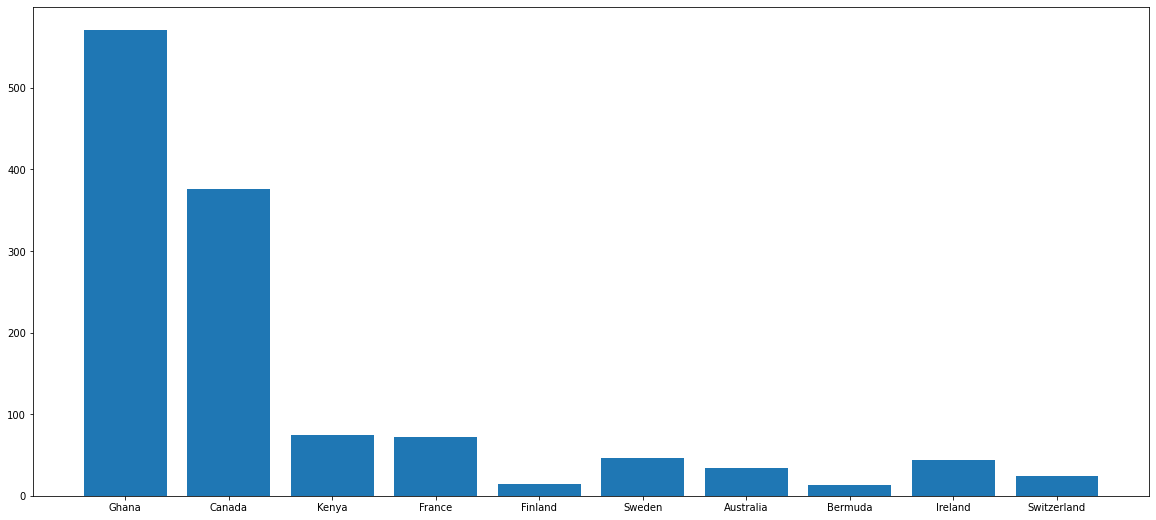

In [33]:
location = []
for loc in tweet_df['user_location'].dropna():
    locs = loc.split()
    location.extend(locs)
    
from collections import Counter
locations = Counter(location)

countries = []
for code, country in Country:
    if country in location:
        countries.append(country)

count_country = {}
for loc in locations:
    if loc in countries and loc!='Nigeria':
        count_country.update({loc:locations[loc]})
        
D = count_country
plt.figure(figsize=(20,9))
plt.bar(range(0,10), list(D.values())[:10], align='center')
plt.xticks(range(0,10), list(D.keys())[:10])

In [26]:
D

{}